In [19]:
import numpy as np
import matplotlib.pyplot as plt
# from serial import Serial # Uncomment this line if you are using the real car
from KITT_Simulator.serial_simulator import Serial # Uncomment this line if you are using the simulator

ModuleNotFoundError: No module named 'ipycanvas'

# Module 4: Car Model

In this Module, we give some basic ingredients to model KITT, you can use this to predict its
behavior.

This module is divided into two parts: a velocity model and a steering model. By the end of the module, you will have created Python code that simulates the car's movement based on a physics models and calibrated by real-world data.

Using the velocity model, you will be able to predict the car's velocity based on the throttle and time. Using the steering model, you will be able to predict the car's steering angle based on the steering wheel angle and time. This will enable you to plan what commands to send to the car to make it move to a desired location.

---

## Velocity Model

### Forces Acting on KITT

We start by driving on a straight line, and consider a simple model of longitudinal KITT dynamics,
described by Newton’s second law. The car’s motion with mass $m$ is influenced by the following three forces:

- $F_{motor}$: The driving force provided by the motor.
- $F_{friction}$: The frictional force opposing the motion, which is proportional to the velocity, $F_{friction} = -b * v$, where b is the friction coefficient.
- $F_{{air}}$: The air resistance, which is proportional to the square of the velocity, $F_{{air}} = -c * v^2$, where c is the air resistance coefficient.

The net force acting on the car can be expressed as:

$$ F_{{net}} = F_{{motor}} - b v - c v^2 $$


 <img src="pictures/KITTwind.jpg" alt="KITTwind" width="350px">

 *Indicate the forces and their directions.* (@B this image is not complete)

Note that another force acting on the car could be the braking force $F_b$. 
Unfortunately, KITT does not have a brake! You can stop by letting KITT roll to standstill, or for a
short period apply a negative force $F_{motor}$. The difference with a real brake is that if you apply $F_{motor}$ for
too long, or were already stopped, the car will drive backwards.

### Newton's Second Law of Motion

According to Newton's second law, the net force acting on the car is equal to the mass of the car times its acceleration:

$$ F_{{net}} = m \frac{dv}{dt} $$

Substituting the expression for $F_{net}$:

$$ m \frac{dv}{dt} = F_{{motor}} - b v - c v^2 $$

### Velocity as a Function of Time

To find the velocity as a function of time, we need to solve the differential equation:

$$ \frac{dv}{dt} = \frac{F_{{motor}}}{m} - \frac{b}{m} v - \frac{c}{m} v^2 $$

This is a nonlinear differential equation due to the $v^2$ term. However, if air resistance is small compared to friction, we can neglect the $c * v^2$  term for a simplified model:

$$ \frac{dv}{dt} = \frac{F_{{motor}}}{m} - \frac{b}{m} v $$

The solution to this first-order linear differential equation is:

$$ v(t) = \frac{F_{{motor}}}{b} \left(1 - e^{-\frac{b}{m}t}\right) $$

### Implementing the Velocity Model
Now we will use the equations above to calculate the velocity of the car over time for a single value of the motor command $F_{motor}$. We also assume some random car parameters for this example simulation below, but note that these values are selected randomly and are not accurate. Later, you will need to calculalte and calibrate these constants for your own car.

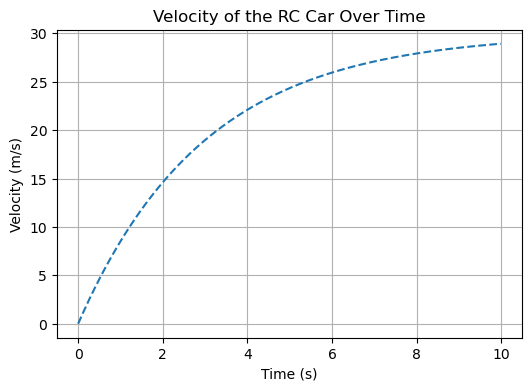

In [3]:
# Car arameters
m = 1.5  # random mass of the car (kg)
b = 0.5  # random friction coefficient (N·s/m)

# motor command
F_motor = 15.0  # random constant motor force (N)

# simulation parameters
dt = 0.01  # time step (s)
t_max = 10.0  # maximum simulation time (s)
# Time array
t = np.arange(0, t_max, dt)

# Velocity array
v = np.zeros_like(t)
# Initial condition
v[0] = 0.0  # initial velocity (m/s)

# Numerical simulation (Euler's method)
for i in range(1, len(t)):
    # Simplified model (without air resistance)
    dv_simplified = (F_motor/m - (b/m) * v[i-1]) * dt
    v[i] = v[i-1] + dv_simplified

# Plotting the results
plt.figure(figsize=(6, 4))
plt.plot(t, v, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity of the RC Car Over Time')
plt.grid(True)
plt.show()
    

### Calibrating the Velocity Model

In this section, you will determine the parameters $F_{motor}$ and $b$. The mass of the car was weighed and is $m=5.6 kg$. To find these parameters, we will closely examine the velocity equation and write some code to make measurements on the car. This part is less guided so you will have to find some of your own sollutions. Remember that the velocity equation is:

$$ v(t) = \frac{F_{{motor}}}{b} \left(1 - e^{-\frac{b}{m}t}\right) $$

With its derivative:

$$ \frac{dv}{dt} = \frac{F_{{motor}}}{m}  \times e^{-\frac{b}{m}t}$$

Note that for sufficiently large $t$, we see that the velocity becomes constant: $v(\infty) = \frac{F_{{motor}}}{b}$. This is called the terminal velocity.

#### Finding the Friction Coefficient $b$

1. **Measure Terminal Velocity:**
   - Run the car at a motor command setting of interest towards a wall. Measure the velocity as the car accelerates until $v_{\infty}$ is reached. For this you can use the distance sensors. _Please place one of the bumber boxes in front of the car to stop it from crashing into the wall._ Transform these distance measurements into a velocity plot.
   
2. **Initial Acceleration:**
   - At the very beginning of the motion, the car starts from rest, and the initial velocity $v(0) = 0$. At this point, frictional forces are negligible since $v$ is small, and the acceleration $dv/dt$ can be approximated by
     $$ \frac{dv}{dt} \approx \frac{F_{{motor}}}{m} $$
   - Measure the acceleration of the car from rest. This can be done by measuring the speed at two very close time intervals after the car starts moving and calculating the acceleration using
     $$ a_0 = \frac{\Delta v}{\Delta t} $$

3. **Calculate $F_{motor}$:**
   - Use the measured initial acceleration $a_0$ to calculate the motor force:
     $$ F_{{motor}} = m \cdot a_0 $$

4. **Calculate $b$ Using Terminal Velocity:**
   - With $F_{{motor}}$ known, use the measured terminal velocity $v_\infty$ to calculate the friction coefficient $b$:
     $$ b = \frac{F_{{motor}}}{v_{{\infty}}} $$

The above process is just one approach. Using measured data, it might be less accurate because it requires you to make a velocity plot (taking numerical derivatives magnifies noise) and then even a second derivative ($a_0$). Alternatively, you can work with a plot of position vs time, and measure the terminal velocity as the slope of the plot for larger time. The time constant $\tau = m/b$ can be determined from a velocity plot by marking the time where the velocity is $1/e \approx 0.368$ of its final value. 

- Once you have estimated your parameters, plot the resulting model curves (for velocity and position) on top of the measured curves. Comment on these plots: how well is the fitting?

- $F_{{motor}}$ depends on the speed setting, and also on the battery status; it will have to be measured again if these values change. For your application, you probably need only one or two speed settings, but you can try to make a calibration table for multiple battery levels.

- The value of $b$ should be independent of the speed setting. If you have a calibration table, can you verify this?

---

## Steering Model

To model the steering behavior of a 4-wheeled car, often the Ackermann steering model is used. However, we will work with a simplified version that models the steering of a bicycle. 

### The Bicycle Steering Geometry


Consider the following figure:

 <img src="bicycle.png" alt="Bicycle Steering" width="350px">

In this figure, we have
- $\theta$: the heading (or orientation) of the car
- $\delta$: the steering angle (you determine this by a steering command)
- $L$: the wheel base
- $R$: the radius of the turning circle
- $\omega = d\theta / d t$: rate of angle change (or angle velocity) 

We choose to measure $R$ with respect to the rear axle. From the geometry, we can then derive the following two equations:
- $\frac{L}{R} = \tan(\delta) \qquad \Rightarrow \quad R = \frac{L}{\tan(\delta)}$
- $\omega = \frac{v}{R}$

To verify this equation, consider that we drive with a constant velocity over an entire circle (rotation angle $2\pi$, circumference $2 \pi R$, driving time $T$):
- $\omega T = 2\pi \quad \Rightarrow \quad \omega = \frac{2\pi}{T}$
- $2\pi R = v T \quad \Rightarrow \quad \omega = \frac{2\pi}{2\pi R}\cdot v = \frac{v}{R}$ 

The expression $R = L/\tan(\delta)$ can be used to create a calibration table: for various steering commands, we measure the resulting $R$ and compute the corresponding $\delta$. If we then apply a new (uncalibrated) angle setting, we can interpolate the table to find $\delta$ and then calculate the corresponding radius $R$.

The expression for $\omega$ will be useful in our implementation of the car model where we integrate over small time steps $\Delta t$.

In [33]:
# Car Parameters
L = 0.3  # Wheelbase (meters)
W = 0.2  # Track width (meters)
R = 1.0  # Desired turning radius (meters)

# Calculate inner and outer steering angles using Ackermann geometry
theta_inner = np.arctan(L / (R - W / 2))
theta_outer = np.arctan(L / (R + W / 2))

# Convert to degrees for easier interpretation
theta_inner_deg = np.degrees(theta_inner)
theta_outer_deg = np.degrees(theta_outer)

print(f"Inner Steering Angle: {theta_inner_deg:.2f} degrees")
print(f"Outer Steering Angle: {theta_outer_deg:.2f} degrees")

Inner Steering Angle: 18.43 degrees
Outer Steering Angle: 15.26 degrees


---

## Building a Unified Car Model

### Introduction

In this chapter, you will learn how to integrate the velocity model and a steering model into a single, unified Python class. For this you will create all sections step-by-step and later combine them into a single class to re-use in your main code.

### Step 1: Setting Up the Car’s Physical Properties

To begin, we need to define the physical properties of KITT. These include its mass, wheelbase, track width, friction coefficient, air resistance coefficient, and maximum motor force. These properties will be used in our calculations.

In [7]:
# Step 1: Define the physical properties of the RC car
mass = 5.6  # kg, mass of the car
wheelbase = 0.3  # m, distance between the front and rear axles
track_width = 0.2  # m, distance between the left and right wheels
friction_coefficient = 3.2  # N·s/m, resistance due to friction
max_motor_force = 4.0  # N, maximum force generated by the motor

### Step 2: Initializing the Car’s State

Next, we need to initialize the state of the car. The state includes the car’s position, velocity, orientation, and the current time. We will store the position as a 2D coordinate (x, y), the velocity as a scalar (speed in meters per second), the orientation as an angle (in radians), and time as a scalar (in seconds).  _In this chapter, the position of the car refers to the center of the rear axle. At some point, you have to translate this to a more useful reference point, i.e. the center of the beacon._

In [8]:
# Step 2: Initialize the car's state
position = np.array([0.0, 0.0])  # (x, y) position in meters
velocity = 0.0  # initial speed in m/s
orientation = 0.0  # initial orientation in radians (0 means facing along the x-axis)
time = 0.0  # start time in seconds

### Step 3: Updating the Car’s Velocity

KITT's velocity depends on the force applied by the motor, as well as the friction and air resistance. You have already derived the equation for updating the velocity:

$$ \text{acceleration} = \frac{F_{{motor}}}{m} - \frac{b}{m} v$$

so that

$$ \text{new velocity} = \text{current velocity} + \text{acceleration} \cdot \Delta t$$

We can now implement this equation as a function in Python:

In [9]:
# Step 3: Define a function to update the car's velocity
def update_velocity(velocity, F_motor, mass, friction_coefficient, dt):
    # Calculate acceleration
    acceleration = (F_motor / mass) - (friction_coefficient / mass) * velocity
    # Update velocity
    velocity += acceleration * dt
    return velocity


### Step 4: Updating the Car’s Orientation

The car’s orientation changes based on the turn radius. The Ackermann steering model helps us determine how much the car’s orientation should change given the current velocity and turning radius.

The change in orientation can be calculated as:

$$ \text{change in orientation} = \frac{\text{velocity}}{\text{turn radius}} \times \Delta t $$

so that

$$ \text{new orientation} = \text{current orientation} + \text{angular velocity} \cdot \Delta t$$

In [11]:
# Step 4: Define a function to update the car's orientation
def update_orientation(orientation, velocity, turn_radius, dt):
    if turn_radius != 0:
        orientation_change = (velocity / turn_radius) * dt
    else:
        orientation_change = 0
    orientation += orientation_change
    return orientation

### Step 5: Updating the Car’s Position

The car’s position changes based on its velocity and orientation. We can use basic trigonometry to update the position:


$$ \text{new position} = \text{current position} + \text{velocity} \times \Delta t \times (\cos(\text{orientation}), \sin(\text{orientation})) $$

In [13]:
# Step 5: Define a function to update the car's position
def update_position(position, velocity, orientation, dt):
    position[0] += velocity * np.cos(orientation) * dt  # Update x-coordinate
    position[1] += velocity * np.sin(orientation) * dt  # Update y-coordinate
    return position

### Step 6: Integrating Everything into a Car Class

Now that you have functions to update each part of the car’s state, it’s convenient to integrate everything into a single class. This class will manage the car’s state and provide an easy interface to simulate its movement.

In [16]:
# Step 6: Create the KITT_Dynamics class
class KITT_Dynamics:
    def __init__(self, mass, wheelbase, track_width, friction_coefficient, max_motor_force):
        # Physical properties of the car
        self.mass = mass
        self.wheelbase = wheelbase
        self.track_width = track_width
        self.friction_coefficient = friction_coefficient
        self.max_motor_force = max_motor_force
        
        # Initial state
        self.position = np.array([0.0, 0.0])  # (x, y) position
        self.velocity = 0.0  # initial velocity in m/s
        self.orientation = 0.0  # initial orientation in radians
        self.time = 0.0  # start time in seconds
        
    def update(self, motor_on, turn_radius, dt):
        # Determine the motor force
        F_motor = self.max_motor_force if motor_on else 0.0
        
        # Update the car's state
        self.velocity = update_velocity(self.velocity, F_motor, self.mass, self.friction_coefficient, dt)
        self.orientation = update_orientation(self.orientation, self.velocity, turn_radius, dt)
        self.position = update_position(self.position, self.velocity, self.orientation, dt)
        
        # Update time
        self.time += dt
    
    def get_state(self):
        return {
            'position': self.position,
            'velocity': self.velocity,
            'orientation': self.orientation,
            'time': self.time
        }

### Step 7: Running the Simulation

With the car model complete, you can now simulate the car’s movement over time. We do this by computing the position of the car in steps of dt, storing the positions in an array, and finally plotting them.

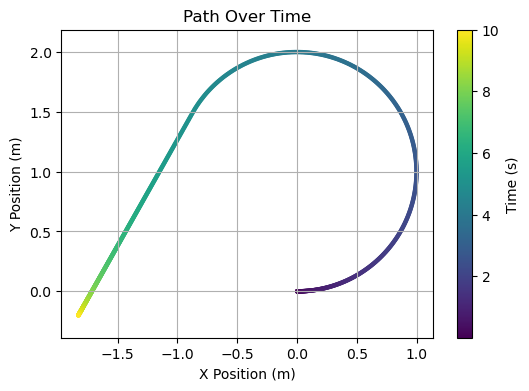

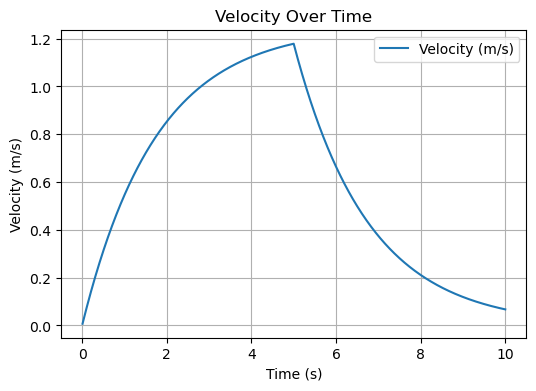

In [18]:
# Step 7: Simulate the car's motion
dt = 0.01  # time step (s)
simulation_time = 10.0  # total simulation time (s)
turn_radius = 1.0  # turn radius in meters (positive for right, negative for left)

# Initialize the car model
car = KITT_Dynamics(mass, wheelbase, track_width, friction_coefficient, max_motor_force)

# Arrays to store the simulation data
positions = []
velocities = []
orientations = []
times = []

# Run the simulation
for t in np.arange(0, simulation_time, dt):
    if t < 5.0:
        car.update(motor_on=True, turn_radius=turn_radius, dt=dt)
    else:
        car.update(motor_on=False, turn_radius=0, dt=dt)
    state = car.get_state()
    
    positions.append(state['position'].copy())
    velocities.append(state['velocity'])
    orientations.append(state['orientation'])
    times.append(state['time'])
    
# Convert to numpy arrays for easier plotting
positions = np.array(positions)
velocities = np.array(velocities)
orientations = np.array(orientations)
times = np.array(times)

# Plotting the car's path with color gradient based on time
plt.figure(figsize=(6, 4))
sc = plt.scatter(positions[:, 0], positions[:, 1], c=times, cmap='viridis', label="Car Path", s=5)
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Path Over Time")
plt.axis('equal')
plt.grid(True)
plt.colorbar(sc, label="Time (s)")
plt.show()

# Plotting the car's velocity over time
plt.figure(figsize=(6, 4))
plt.plot(times, velocities, label="Velocity (m/s)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Over Time")
plt.grid(True)
plt.legend()
plt.show()

The scripts shown above are able to create realistic car tracks. However, they need to be extended/adjusted by you to take into account:
- translation of your speed setting command to a corresponding $F_{{motor}}$
- translation of your steering setting command to a corresponding turning circle $R$
- translation of the internally tracked position (real axle) to a better reference point (car beacon)
- nonzero initial conditions

## Mid-term assessment and report

In the midterm assessment, the TA will give you a short series of driving/steering commands (e.g., M165,
D150 for 0.5 sec, D170 for 0.5 sec, stop), your model predicts the position, and this is compared to the
actual position of KITT after following the same series of commands.
In the midterm report, present the model, and present test results that shows the accuracy of this model,
starting from a known state. Summarize in a conclusion: over what time period can you predict the new
position of the car with an accuracy better than 30 cm?

## After the Midterm

After the midterm, you will work on a controller that takes you from A to B. For this you will need to use a transformation of the equations given here, so make sure you understand what you are doing.

**Optional extensions:**
Even when standing still or moving short distances (~10cm) your beacon estimations will jump around. Your car model estimations will be more accurate when moving short distances. However, the car model does not get feedback, so the error adds up over time. The beacons error stays constant over time. You could think of fusing these estimations. For optimal fusion, you need to know the accuracy
(variance) of each of the estimates, so you can take a weighted average. You can also use the model predictions to detect and reject possible outliers from the beacon method. 

You will probably find that the car behavior is not constant; e.g., the velocity response depends on the battery status and also (slightly) on the steering setting. You could extend your model to take that into account.